In [1]:
from artifacts_ipv6_sra_scanning.config import *
import pickle
import os
import ipaddress
import geopandas as gpd

import pycountry
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
from parallel_pandas import ParallelPandas
ParallelPandas.initialize(n_cpu=24, split_factor=1, disable_pr_bar=False)

2025-10-08 19:12:00.968 | INFO     | artifacts_ipv6_sra_scanning.config:<module>:22 - PROJ_ROOT path is: /home/service/artifacts-ipv6-sra-scanning


In [2]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import datetime
import matplotlib.pyplot as plt

In [3]:
import glob

In [4]:
data_dir = "/home/service/ipv6-measurements-mkoch/backup_2024/sra-analysis"

In [5]:
files = glob.glob(f'{DATA_DIR}/stability_scans/*.log.zst')

In [6]:
files.sort()

In [7]:
files

['/home/service/artifacts-ipv6-sra-scanning/data/stability_scans/zmap_icmp_routerstability_1730764801.log.zst',
 '/home/service/artifacts-ipv6-sra-scanning/data/stability_scans/zmap_icmp_routerstability_1730786401.log.zst',
 '/home/service/artifacts-ipv6-sra-scanning/data/stability_scans/zmap_icmp_routerstability_1730808001.log.zst',
 '/home/service/artifacts-ipv6-sra-scanning/data/stability_scans/zmap_icmp_routerstability_1730829601.log.zst',
 '/home/service/artifacts-ipv6-sra-scanning/data/stability_scans/zmap_icmp_routerstability_1730851201.log.zst',
 '/home/service/artifacts-ipv6-sra-scanning/data/stability_scans/zmap_icmp_routerstability_1730872801.log.zst',
 '/home/service/artifacts-ipv6-sra-scanning/data/stability_scans/zmap_icmp_routerstability_1730894401.log.zst',
 '/home/service/artifacts-ipv6-sra-scanning/data/stability_scans/zmap_icmp_routerstability_1730916001.log.zst',
 '/home/service/artifacts-ipv6-sra-scanning/data/stability_scans/zmap_icmp_routerstability_1730937601.lo

In [8]:
def load_and_join(files):
    df = pl.DataFrame()
    for i in tqdm(range(len(files))):
        if df.is_empty():
            df = pl.read_csv(files[i],columns=['saddr','classification'])
            df = df.filter(pl.col('classification')=='echoreply').select('saddr').unique()
            df = df.with_columns(inscan=True)
        else:
            tmp = pl.read_csv(files[i],columns=['saddr','classification'])
            tmp = tmp.filter(pl.col('classification')=='echoreply').select('saddr').unique()
            tmp = tmp.with_columns(inscan=True)
            df = df.join(tmp,on=['saddr'],how='full', suffix=f'_s{i}',coalesce=True)
            
    return df

In [9]:
df = load_and_join(files)

  0%|          | 0/14 [00:00<?, ?it/s]

In [10]:
for ts in [1730764801,
           1730786401,
           1730808001,
           1730829601,
           1730851201,
           1730872801,
           1730894401,
           1730916001,
           1730937601,
           1730959201,
           1730980801,
           1731002401,
           1731024001,
           1731456001]:
    value = datetime.datetime.fromtimestamp(ts)
    print(value.strftime('%Y-%m-%d %H:%M:%S'))

2024-11-05 00:00:01
2024-11-05 06:00:01
2024-11-05 12:00:01
2024-11-05 18:00:01
2024-11-06 00:00:01
2024-11-06 06:00:01
2024-11-06 12:00:01
2024-11-06 18:00:01
2024-11-07 00:00:01
2024-11-07 06:00:01
2024-11-07 12:00:01
2024-11-07 18:00:01
2024-11-08 00:00:01
2024-11-13 00:00:01


In [11]:
columns = ['inscan','inscan_s2','inscan_s6','inscan_s8','inscan_s10','inscan_s11','inscan_s12']

In [12]:
colors = ["#375E97", "#FB6542", "#c1195c", "#37975e"]
linestyles = ['--','solid','-.',':']

In [13]:
df = df.with_columns(sumscans=pl.sum_horizontal(['inscan','inscan_s2','inscan_s6','inscan_s8','inscan_s10','inscan_s11','inscan_s12']))

In [14]:
x = [i for i in range(1,8)]
y1 = []
y2 = []
y3 = []
for column in ['inscan','inscan_s2','inscan_s6','inscan_s8','inscan_s10','inscan_s11','inscan_s12']:
    yv1 = df.filter(pl.col(column)).select('saddr').n_unique()
    y1.append(yv1)
    yv2 = df.filter((pl.col(column)) & 
                   (pl.col('sumscans')==7)).select('saddr').n_unique()
    y2.append(yv2)

In [21]:
df.write_parquet(f'{INTERIM_DATA_DIR}/visibility-df.parquet')

In [17]:
df

saddr,inscan,inscan_s1,inscan_s2,inscan_s3,inscan_s4,inscan_s5,inscan_s6,inscan_s7,inscan_s8,inscan_s9,inscan_s10,inscan_s11,inscan_s12,inscan_s13,sumscans
str,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,u32
"""2800:190:4000:33:d020:36dd:d95…",true,true,true,true,true,true,true,true,true,true,true,true,true,true,7
"""2806:290:a80a:59:fa6e:eeff:fe1…",true,true,true,true,true,true,true,true,true,true,true,true,null,null,6
"""2402:800:63ad:2cfa:c4f2:3a27:2…",true,true,true,true,true,true,true,true,true,true,true,true,true,true,7
"""2409:8a1e:80a:d71a:9247:3cff:f…",true,true,true,true,true,true,true,true,true,true,true,true,true,true,7
"""2800:190:4000:2600:54a2:d33d:a…",true,true,true,true,true,true,true,true,true,true,true,true,true,true,7
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2406:7400:109:9a95::1""",null,null,null,null,null,null,null,null,null,null,null,null,null,true,0
"""2406:7400:9b:7b01::1""",null,null,null,null,null,null,null,null,null,null,null,null,null,true,0
"""2804:3d28:44:4077::1""",null,null,null,null,null,null,null,null,null,null,null,null,null,true,0


In [15]:
plt.rc("font", size=12)

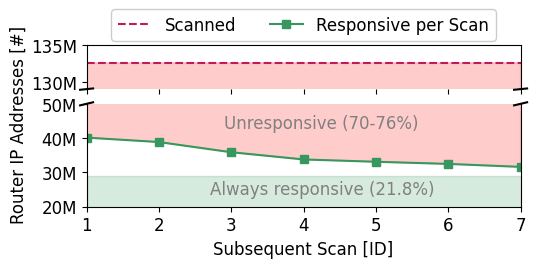

In [24]:
# If we were to simply plot pts, we'd lose most of the interesting
# details due to the outliers. So let's 'break' or 'cut-out' the y-axis
# into two portions - use the top (ax) for the outliers, and the bottom
# (ax2) for the details of the majority of our data
f, (ax, ax2) = plt.subplots(2, 1, sharex=True,figsize=(8*0.7,3*0.7),gridspec_kw={'height_ratios':[0.3,0.7]})

# plot the same data on both axes
ax.axhline(132571352,linestyle='--',color=colors[2],label='Scanned')
ax2.plot(x,y1,marker='s',label='Responsive per Scan',color=colors[3])

# zoom-in / limit the view to different portions of the data
ax.set_ylim(129*10**6, 135*10**6)  # outliers only
ax2.set_ylim(2*10**7,5*10**7)

ax.set_xlim(1,7)
ax.set_yticks([13*10**7,13.5*10**7])
ax.set_yticklabels(['130M','135M'])

ax.set_xticks([])
ax2.set_xticks([1,2,3,4,5,6,7])
# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

ax2.set_yticks([2*10**7,3*10**7,4*10**7,5*10**7])
ax2.set_yticklabels(['20M','30M','40M','50M'])
ax2.set_xlabel('Subsequent Scan [ID]')
ax2.set_ylabel('Router IP Addresses [#]')
h1,l1 = ax.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2,l1+l2,loc='upper center',ncol=2,bbox_to_anchor=(0.5,2),framealpha=1)
#ax2.grid(axis='y')

ax2.yaxis.set_label_coords(-0.135, 0.8)

#ax2.axhline(y2[0],linestyle='--',color=colors[3])
ax2.axhspan(0,y2[0],0,8,color=colors[3], alpha=0.2)
ax2.text(2.7,2.35*10**7,'Always responsive (21.8%)',color='grey')
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

ax2.text(2.9,4.3*10**7,'Unresponsive (70-76%)',color='grey')

ax2.fill_between(
    x,y1, [132571352]*7, 
    interpolate=True, color="red", alpha=0.2
)
ax.fill_between(
    x,y1, [132571352]*7, 
    interpolate=True, color="red", alpha=0.2
)

#f.subplots_adjust(hspace=0.01)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.savefig('../reports/figures/routerstability.pdf',bbox_inches='tight')

plt.show()
plt.close()

In [ ]:
y2[0]/132571352*100

In [ ]:
(1-(y1[0]/132571352))*100

In [ ]:
(1-y1[-1]/132571352)*100

In [ ]:
y1 #[40149181, 38854671, 35885420, 33779016, 33105186, 32481363, 31612755]

In [ ]:
y2 #[28843348, 28843348, 28843348, 28843348, 28843348, 28843348, 28843348]